# Creating Jazz Music with LSMT Network

In this notebook, I will implement a model that uses an LSTM to generate Jazz music.

**In this assignment, I learned to:**

- Apply an LSTM to a music generation task
- Generate my own jazz music with deep learning
- Use the flexible Functional API to create complex models

This is part of the deep learning specialization course on coursera. I am deeply greatful to Andrew Ng and the deeplearning.ai team for allowing us to learn the science and techniques of deep learning. 

**Let's Get Started**

In [1]:
import IPython
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from music21 import *
from grammar import *
from qa import *
from preprocess import *
from music_utils import *
from data_utils import *
from outputs import *
from test_utils import *

from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Introduction

Building a neural network to predict values is a complex task and requires several steps. 

**Step 1: Explore the data and understand the dimensions** <br>
This is a very important step before starting to build a neural network. In this field there are numerous operations to be undertaken. When you have a firm understanding of the dimensions of the tensors/matrices/vectors you are manipulating you will find it much easier to write these operations and avoid errors in your code. Trust me, it will be much more fun! Curb your enthousiasm to get to the training and predict part and spend the time understanding the dimensions of your inputs/outputs/hidden states/cell states/weights/bias vectors etc..  

**Step 2: Build the model** <br> Now, you need to come up (or borrow) the architecture of the neural network you want to use. Again, it is very important and interesting to look under the hood and see what is happening,i.e. what are the operations, taking place within the network. What are the inputs and the ouputs. What are the internal operations taking place. After you've done that you need to follow these steps:
* Define the shareable weights (this is because in LSTM these weights will be shared across all cells)
* Build the function that will create a model instance/object. Check out the architecture using the .summary() function
* Train the model using .fit(). You will have to choose the optimizer, loss method and accuracy metric.

**Step 3: Predict** <br> This will follow similar sub steps as step 2: 

* uild te function that you will use to create an inference/predicting object/instance. Check out the architecture using the .summary() function
* reate a model instance/object using the function
* se the model to predict new values



# Step 1: Understand input and output data and their dimensions.

In [2]:
X, Y, n_values, indices_values, chords = load_music_utils('data/original_metheny.mid')
print('Number of training examples:', X.shape[0])
print('Tx (length f sequence):', X.shape[1])
print('Total # of unique values:', n_values)
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)
print('Number of chords', len(chords))

Number of training examples: 60
Tx (length f sequence): 30
Total # of unique values: 90
Shape of X: (60, 30, 90)
Shape of Y: (30, 60, 90)
Number of chords 19


From the deep learning specialization course: 

You have just loaded the following:

- `X`: This is an (m, $T_x$, 90) dimensional array. 
    - You have m training examples, each of which is a snippet of $T_x =30$ musical values. 
    - At each time step, the input is one of 90 different possible values, represented as a one-hot vector. 
        - For example, X[i,t,:] is a one-hot vector representing the value of the i-th example at time t. 

- `Y`: a $(T_y, m, 90)$ dimensional array
    - This is essentially the same as `X`, but shifted one step to the left (to the past). 
    - Notice that the data in `Y` is **reordered** to be dimension $(T_y, m, 90)$, where $T_y = T_x$. This format makes it more convenient to feed into the LSTM later.
    - Similar to the dinosaur assignment, you're using the previous values to predict the next value.
        - So your sequence model will try to predict $y^{\langle t \rangle}$ given $x^{\langle 1\rangle}, \ldots, x^{\langle t \rangle}$. 

- `n_values`: The number of unique values in this dataset. This should be 90. 

- `indices_values`: python dictionary mapping integers 0 through 89 to musical values.

- `chords`: Chords used in the input midi

# Step 2: Build the model

First establish the architecture of the mdodel.

<img src="images/music_generation.png" style="width:600;height:400px;">
<caption><center><font color='purple'><b>Figure 1</b>: Basic LSTM model </center></caption>

I will use a hidden state made up of 64 units. 

The LSTM's weights are to be defined outside the loop so that the same are shared across the entire sequence. 

Loop over the sequence size. At each time step: 

* the LSTM will take a slice of X whose size will be (1,1,90) and the previous hidden state of size (1,64).

* LSTM will output a the time step's hidden state and cell state. Both are of size (1,64) 

* The time step's hidden state is fed into the densor (here with softmax activation), and generate an output of size (1,90) 

* The above steps will be repeated for all 


Let's define the shareable weights

In [3]:
n_a = 64  #number of hidden units
reshaper = Reshape((1,n_values)) # its role is to reshape its input into a tensor so that it can be fed to the LSTM layer
LSTM_cell = LSTM(n_a, return_state = True)# to feed the time step's hidden state into the Dense layer, we need to activate the return state.
# if we had a stacked LSTM, we would activate return_sequence so that the hidden state and cell state are both fed to the next LSTM cell. 
densor = Dense(n_values, activation = 'softmax')

Now let's build the model that will be trained.

In [4]:
def jazzTrainingModel(Tx, LSTM_cell, densor, reshaper):
        """
    Builds the jazzTrainingModel composed of Tx LSTM cells where each cell is responsible
    for learning the following note based on the previous note and context.
    Each cell has the following schema: 
            [X_{t}, a_{t-1}, c0_{t-1}] -> RESHAPE() -> LSTM() -> DENSE()
    Arguments:
        Tx -- length of the sequences in the corpus
        LSTM_cell -- LSTM layer instance
        densor -- Dense layer instance
        reshaper -- Reshape layer instance
    
    Returns:
        model -- a keras instance model with inputs [X, a0, c0]
    """
        n_a = LSTM_cell.units #shape of the hidden and cell state
        n_values = densor.units #shape of the input and output
        
        X = Input(shape = (Tx, n_values)) #this tensor containts the input,i.e., the values at each time step of the sequence
        
        a0 = Input(shape = (n_a,), name = "a0") #initial hidden state
        c0 = Input(shape = (n_a,), name = "c0") #initial cell state
        a = a0 
        c = c0
        
        outputs = [] #i will append the densor outputs to this list
        
        for i_Tx in range(0,Tx):
            x = X[:,i_Tx,:] # select the "t"th element of the sequence
            x = reshaper(x)
            
            a, _, c = LSTM_cell(inputs = x, initial_state = [a,c]) # apply the LSTM cell to get the new hidden and cell states
            output = densor(a) #apply the densor to get the output
            
            outputs.append(output) #append to the list of outputs to be used in training the model
            
        model = Model(inputs = [X, a0, c0], outputs = outputs) #create a model instance
        
        return model
        
        
    

Now we will create a model object for input sequences of size Tx = 30.

In [5]:
model = jazzTrainingModel(Tx = 30, LSTM_cell = LSTM_cell, densor = densor, reshaper = reshaper)

Check out the model architecture using model.summary

In [6]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 90)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 90)]         0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 90)        0           tf_op_layer_strided_slice[0][0]  
                                                                 tf_op_layer_strided_slice_1[0][0]
                                                                 tf_op_layer_strided_slice_2[0][0]
                                                                 tf_op_layer_strided_sl

# Step 3: Train the model

Now that the model is built, we need to compile it by providing the optimization technique, the method to measure loss and the metric to measure accuracy.

In [7]:
opt = Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01)
model.compile(optimizer= opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

Now let's train the model! We will need to define the inputs, and the labeled data. 

In [8]:
m = X.shape[0] # number of training examples
a0 = np.zeros((m,n_a)) #hidden state with n_a hidden units
c0 = np.zeros((m,n_a)) #cell state with n_a units

history = model.fit([X, a0, c0], list(Y), epochs = 100, verbose = 0)


loss at epoch 1: 129.83811950683594
loss at epoch 100: 9.432437896728516


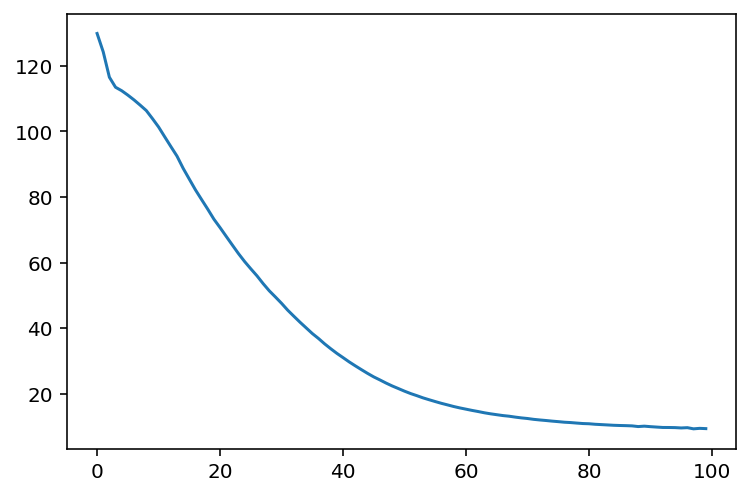

In [9]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch 100: {history.history['loss'][99]}")
plt.plot(history.history['loss'])

# Step 4: Predict

Now that we trained out model, we can use it to predict values given a certain sample. To do that we need to build an inference instance/object. This time, instead of iterating over a sequence Tx, we will provide one input sample only. The output of the first LSTM cell will be the input for the next (see Figure below).
<img src="images/music_gen.png" style="width:600;height:400px;">
<center><caption><b><font color='purple'>Figure 2: Generating new values in an LSTM </b></font>

Let's get to it and build the inference model/instance.

In [10]:
def LSTM_inference_model(LSTM_cell, densor, Tx = 100):
    ''' Uses the trained LSTM/densor network to predict a sequence of values given the first element.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Tx -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance'''
    n_values = densor.units #the number of features the input and output can have.
    n_a = LSTM_cell.units #the number of units the hidden and cell states have
    
    x0 = Input(shape = (1,n_values)) #Input
    a0 = Input(shape = (n_a)) #Hidden state
    c0 = Input(shape = (n_a,)) #Cell state
    #Now we need to introdue a hidden and cell state variables that will start at a0 and c0 values but then change as 
    # we go through the loop.
    a = a0
    c = c0
    x = x0
    
    outputs = [] #list to store all the outputs of each timestep (the elements of the Tx sequence to be generated)
    
    for i_Tx in range(0,Tx):#iterate Tx times to generate a sequence of length Tx
        a, _, c = LSTM_cell(inputs = x, initial_state = [a,c]) #get the present time step's hidden and cell states
        output = densor(a) #use the time step's hidden state to calcule the output (which will be the input for the next time step)
        outputs.append(output)
        
        #the densor produces probabilistic values for each feature. We need to convert that into a one-hot vector.
        #Feature with maximum probability is equal to one. Everything else is 0. 
        x = tf.math.argmax(output, axis = -1) # this will give the index of the feature with max probability for each of the m (batch size) training examples. 
        x = tf.one_hot(x, n_values) #generates the tensor with one-hot vectors.
        
        #Now for x to be ready to be used as input for the next LSTM cell, we need to make sure it is of shape (None, 1, 90)
        x = RepeatVector(1)(x)
        
    #Now let's create a model instance
    inference_model = Model(inputs = [x0, a0, c0], outputs = outputs)
    
    return inference_model
        
        
        
        
        
    

In [11]:
inference_model = LSTM_inference_model(LSTM_cell, densor, Tx = 50)

In [12]:
inference_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 90)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64), (None,  39680       input_2[0][0]                    
                                                                 input_3[0][0]         

Now let's predict

In [23]:
x0 = np.zeros(shape = (1,1,n_values))
a0 = np.zeros(shape = (1,n_a))
c0 = np.zeros(shape = (1,n_a))

#Step 1: get the predictions. This will be a sequence of vectors where each vector has 90 elements. Each of these elements will be a probability.
pred = inference_model.predict([x0, a0, c0])

#Step 2: For each vector of the sequence, get the index of the element with maximum probability
max_indices = np.argmax(pred, axis = 2)

#Step 3: transform these indices into one-hot vectors
results = to_categorical(max_indices, num_classes = X.shape[2])

In [24]:
print("np.argmax(results[12]) = ", np.argmax(results[12]))

np.argmax(results[12]) =  66


Now let's generate some music

In [25]:
out_stream = generate_music(inference_model, indices_values, chords)

Predicting new values for different set of chords.
Generated 34 sounds using the predicted values for the set of chords ("1") and after pruning
Generated 34 sounds using the predicted values for the set of chords ("2") and after pruning
Generated 34 sounds using the predicted values for the set of chords ("3") and after pruning
Generated 34 sounds using the predicted values for the set of chords ("4") and after pruning
Generated 34 sounds using the predicted values for the set of chords ("5") and after pruning
Your generated music is saved in output/my_music.midi


In [26]:
mid2wav('output/my_music.midi')
IPython.display.Audio('./output/rendered.wav')